<a href="https://colab.research.google.com/github/AshHydroCoder/GRACE-Downscaler/blob/Branch1/Making_raw_files_for_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cftime
!pip install metpy
!pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.9/409.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.3 MB/s eta 0:00:00


In [2]:
import rioxarray
import numpy as np
from numpy import *
import xarray as xr
import metpy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Missing Month List of GRACE

In [5]:
grace_nc ='/content/drive/MyDrive/Thesis/RAW/GRACE_CSR.nc'
G_dataset = xr.open_dataset(grace_nc)
months_missing = G_dataset.attrs.get('months_missing', 'Attribute not found')
dates = months_missing.replace(",", ";").split(";")
missing_dates = [(int(date.split("-")[0]), int(date.split("-")[1])) for date in dates]
missing_dates = [pd.Timestamp(year=year, month=month, day=1) for year, month in missing_dates]
#print(missing_dates)
#G_dataset_clip = G_dataset.sel(time=slice('2003-02-01','2020-12-31'))
#G_dataset_clip = G_dataset_clip[['lwe_thickness']]
#df1 = G_dataset_clip.to_dataframe().reset_index()
# Export to CSV
#df1.to_csv('D:/Masters/Thesis/Data/RFM/'+what+'.csv', index=False)
missing_dates


[Timestamp('2002-06-01 00:00:00'),
 Timestamp('2002-07-01 00:00:00'),
 Timestamp('2003-06-01 00:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2011-06-01 00:00:00'),
 Timestamp('2012-05-01 00:00:00'),
 Timestamp('2012-10-01 00:00:00'),
 Timestamp('2013-03-01 00:00:00'),
 Timestamp('2013-08-01 00:00:00'),
 Timestamp('2013-09-01 00:00:00'),
 Timestamp('2014-02-01 00:00:00'),
 Timestamp('2014-07-01 00:00:00'),
 Timestamp('2014-12-01 00:00:00'),
 Timestamp('2015-06-01 00:00:00'),
 Timestamp('2015-10-01 00:00:00'),
 Timestamp('2015-11-01 00:00:00'),
 Timestamp('2016-04-01 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2016-10-01 00:00:00'),
 Timestamp('2017-02-01 00:00:00'),
 Timestamp('2017-02-01 00:00:00'),
 Timestamp('2017-07-01 00:00:00'),
 Timestamp('2017-08-01 00:00:00'),
 Timestamp('2017-09-01 00:00:00'),
 Timestamp('2017-10-01 00:00:00'),
 Timestamp('2017-11-01 00:00:00'),
 Timestamp('2017-12-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-02-

In [ ]:
G_dataset

<xarray.Dataset> Size: 987MB
Dimensions:        (lon: 1440, lat: 720, time: 238)
Coordinates:
  * lon            (lon) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * lat            (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time           (time) datetime64[ns] 2kB 2002-04-18 ... 2024-10-16T12:00:00
Data variables:
    WGS84          int64 8B ...
    lwe_thickness  (time, lat, lon) float32 987MB ...
Attributes: (12/59)
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    filename:                   netcdf/CSR_GRACE_GRACE-FO_RL0603_Mascons_all-...
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    title:                      CSR GRACE and GRACE-FO MASCON RL0603M
    subtitle:                   RL06.2 GRACE/GRACE-FO Total water storage wit...
    ...                         ...
    user_note_3:                Ellipsoidal correction has been applied. The ...
    user_note_4:                This GRACE-FO RL06.2 data is an updated versi...
    date_created:               2025-01-06T11:43:54Z
    variable:                   liquid water equivalent thickness
    label:                      RL0603rc24cE
    Mask:                       Global

# Load Shape

In [8]:
cluster = "AQ"
nepal_shp = gpd.read_file('/content/drive/MyDrive/Thesis/SHP/AOI.shp')
nepal_shp = nepal_shp.set_crs('epsg:4326')
nepal_shp

,OBJECTID,L1_code,L1_Name,L2_code,L2_Name,L3_code,L3_Name,Mcode,ID,Remarks,layer,path,geometry
0,78,5O,Ganga,None,Karnali,None,Kali,None,16,None,None,None,"POLYGON Z ((80.15825 28.67788 0, 80.15814 28.6..."
1,67,5O,Ganga,None,Ghaghara,None,Ghaghara,None,5,None,Ghaghara,C:/Users/Hp/Desktop/shp/Ghaghara.shp,"POLYGON Z ((82.5635 28.56713 0, 82.56629 28.56..."
2,68,5O,Ganga,None,Gandaki,None,Trunk Gandaki,None,6,None,Trunk Gandaki,C:/Users/Hp/Desktop/shp/Trunk Gandaki.shp,"POLYGON Z ((83.94234 28.06281 0, 83.94382 28.0..."
3,76,5O,Ganga,None,Karnali,None,Trunk Karnali,None,14,None,Trunk Karnali,C:/Users/Hp/Desktop/shp/Trunk Karnali.shp,"POLYGON Z ((81.85099 29.62483 0, 81.85116 29.6..."
4,66,5O,Ganga,5O3,Koshi,5O3_8,Trunk Koshi,None,4,None,Trunk Koshi,C:/Users/Hp/Desktop/shp/Trunk Koshi.shp,"POLYGON Z ((85.46197 27.80713 0, 85.46349 27.8..."
5,66,5O,Ganga,5O3,Trunk Ganga,5O3_8,Trunk Koshi,None,1,None,Trunk Koshi,C:/Users/Hp/Desktop/shp/Trunk Koshi.shp,"POLYGON Z ((84.11388 27.51747 0, 84.11396 27.5..."


## Exclude times not available in GRACE

## Raw files for RFM

### Precipitation

In [9]:
pr_nc = "/content/drive/MyDrive/Thesis/REGRID/IMERG 0.25.nc"
pr_dataset = xr.open_dataset(pr_nc)
pr_dataset = pr_dataset.rio.write_crs('epsg:4326')
pr_dataset = pr_dataset.rio.clip(nepal_shp.geometry,all_touched=True)
pr_dataset = pr_dataset.rename({'lon':'x','lat':'y'})
pr_dataset = pr_dataset.transpose('time','x', 'y')
print(pr_dataset)

<xarray.Dataset> Size: 547kB
Dimensions:        (time: 252, x: 30, y: 18)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2003-01-01 ... 2023-12-01
  * x              (x) float64 240B 80.12 80.38 80.62 ... 86.88 87.12 87.38
  * y              (y) float64 144B 25.38 25.62 25.88 ... 29.12 29.38 29.62
    spatial_ref    int64 8B 0
Data variables:
    precipitation  (time, x, y) float32 544kB nan nan nan nan ... nan nan nan
Attributes:
    CDI:                                    Climate Data Interface version 1....
    Conventions:                            CF-1.6
    Original_Producer_Metadata_FileHeader:  DOI=10.5067/GPM/IMERG/3B-MONTH/07...
    Original_Producer_Metadata_FileInfo:    DataFormatVersion=7e;\nTKCodeBuil...
    Original_Producer_Metadata_GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegis...
    InputPointer:                           3B-MO.MS.MRG.3IMERG.20030101-S000...
    history_L34RS:                          'Created by L34RS v1.4.4 @ NASA G...
    CDO:         

In [ ]:
pr_dataset.to_netcdf('drive/MyDrive/Thesis/check.nc')

In [14]:
#pr_dataset['time'] = pd.to_datetime(pr_dataset.indexes['time'].to_datetimeindex())  #if the time is not in standard format

time_index = pd.to_datetime(pr_dataset['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for timestamp in missing_dates:
    year = timestamp.year
    month = timestamp.month
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
filtered_dataset = pr_dataset.sel(time=mask[mask].index)
filtered_dataset = filtered_dataset.sel(time=slice('2003-01-01','2023-12-31'))

pr_df = filtered_dataset.to_dataframe().reset_index()
pr_df = pr_df.drop(columns='spatial_ref')
pr_df = pr_df.sort_values(by=['time','x'])
pr_df


,time,x,y,precipitation
0,2003-01-01,80.125,25.375,NaN
1,2003-01-01,80.125,25.625,NaN
2,2003-01-01,80.125,25.875,NaN
3,2003-01-01,80.125,26.125,NaN
4,2003-01-01,80.125,26.375,NaN
...,...,...,...,...
119335,2023-12-01,87.375,28.625,NaN
119336,2023-12-01,87.375,28.875,NaN
119337,2023-12-01,87.375,29.125,NaN
119338,2023-12-01,87.375,29.375,NaN


In [16]:
# Export to CSV
os.makedirs(os.path.dirname(f'/content/drive/MyDrive/Thesis/RFM/Training/precipitation.csv'), exist_ok=True)
pr_df.to_csv(f'/content/drive/MyDrive/Thesis/RFM/Training/precipitation.csv', index=False)


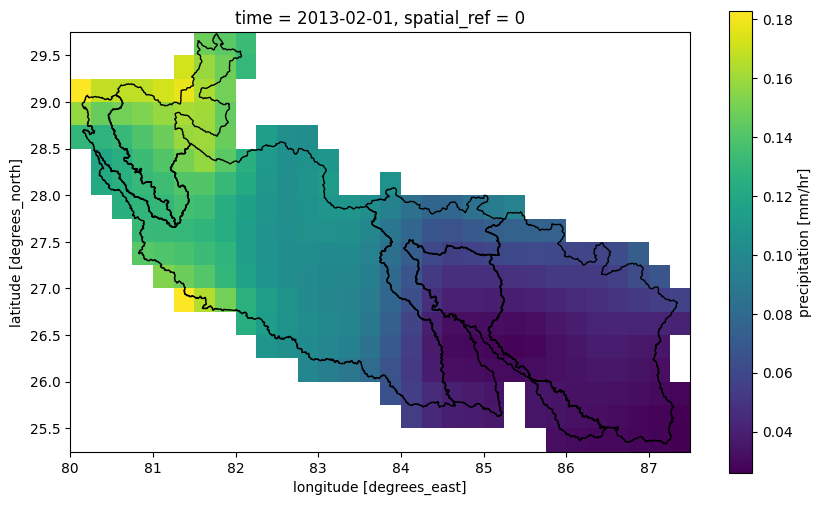

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

# Transpose the dataset to switch lat (y) and lon (x)
pr_dataset_transposed = pr_dataset.precipitation.isel(time=121).transpose('y', 'x')
pr_dataset_transposed.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

#num_panels = GR_Clip.lwe_thickness.isel(time = 1).size
#print(num_panels)

### CHIRPS

In [ ]:
chirps_path = "D:\Masters\Thesis\Data\CHIRPS.nc"
CHIRPS = xr.open_dataset(chirps_path)
CHIRPS = CHIRPS.rename({'longitude':'x','latitude':'y'})
regrid_lat = np.arange(21.125,32.125,0.25)
regrid_lon = np.arange(76.125,92.125,0.25)
CHIRPS_regrid = CHIRPS.interp(y = regrid_lat, x = regrid_lon,method='slinear')
CHIRPS_regrid

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Hp\AppData\Local\Temp\ipykernel_8460\1210551659.py:1: SyntaxWarning: invalid escape sequence '\M'
  chirps_path = "D:\Masters\Thesis\Data\CHIRPS.nc"


<xarray.Dataset>
Dimensions:  (time: 252, y: 44, x: 64)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2020-12-31
  * y        (y) float64 21.12 21.38 21.62 21.88 ... 31.12 31.38 31.62 31.88
  * x        (x) float64 76.12 76.38 76.62 76.88 ... 91.12 91.38 91.62 91.88
Data variables:
    precip   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [ ]:
CHIRPS_25 = CHIRPS_regrid.rio.write_crs('epsg:4326')
CHIRPS_25 = CHIRPS_25.rio.clip(nepal_shp.geometry,all_touched=True)
CHIRPS_25

<xarray.Dataset>
Dimensions:      (time: 252, y: 4, x: 12)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2020-12-31
  * y            (y) float64 26.38 26.62 26.88 27.12
  * x            (x) float64 85.38 85.62 85.88 86.12 ... 87.38 87.62 87.88 88.12
    spatial_ref  int32 0
Data variables:
    precip       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [ ]:
#CHIRPS_25['time'] = pd.to_datetime(CHIRPS_25.indexes['time'].to_datetimeindex())  #if the time is not in standard format

time_index = pd.to_datetime(CHIRPS_25['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for timestamp in missing_dates:
    year = timestamp.year
    month = timestamp.month
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
filtered_CHIRPS = CHIRPS_25.sel(time=mask[mask].index)
filtered_CHIRPS = filtered_CHIRPS.sel(time=slice('2003-02-01','2016-12-31'))

CHIRPS_DF = filtered_CHIRPS.to_dataframe().reset_index()
CHIRPS_DF = CHIRPS_DF.drop(columns='spatial_ref')
CHIRPS_DF = CHIRPS_DF.sort_values(by=['time','x'])
CHIRPS_DF
# Export to CSV
CHIRPS_DF.to_csv(f'D:/Masters/Thesis_New/Terai/RFM/chirps.csv', index=False)


### FLDAS

#### Automate for FLDAS

In [ ]:
# Needs FLDAS data that are exported to 0.25 degree resolution in a single folder
# Define the folder containing the .nc files and the shapefile
nc_folder = '/content/drive/MyDrive/Thesis/REGRID/FLDAS'
output_folder = f'/content/drive/MyDrive/Thesis/RFM/Training/{cluster}'

# Load the shapefile
#nepal_shp = gpd.read_file(shapefile_path)

# List all .nc files in the folder
nc_files = [f for f in os.listdir(nc_folder) if f.endswith('.nc')]

# Loop through each .nc file
for nc_file in nc_files:
    # Define the full path of the .nc file
    file_path_nc = os.path.join(nc_folder, nc_file)

    # Open the dataset
    ev_dataset = xr.open_dataset(file_path_nc)

    # Assign the coordinate system and clip the data using the shapefile
    ev_dataset = ev_dataset.rio.write_crs('epsg:4326')
    ev_dataset = ev_dataset.rio.clip(nepal_shp.geometry, all_touched=True)

    # Rename the dimensions and transpose the dataset
    ev_dataset = ev_dataset.rename({'lon': 'x', 'lat': 'y'})
    ev_dataset = ev_dataset.transpose('time', 'x', 'y')

    # Plot the data for a specific time (you can adjust the time step if needed)
    fig, ax = plt.subplots(figsize=(10, 6))
    ev_dataset_transposed = ev_dataset[list(ev_dataset.data_vars)[0]].isel(time=121).transpose('y', 'x')
    ev_dataset_transposed.plot(ax=ax)
    nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')
    plt.show()

    # Convert time to a standard format if needed
   # if 'time' in ev_dataset.coords:
        #ev_dataset['time'] = pd.to_datetime(ev_dataset.indexes['time'].to_datetimeindex())

    # Define missing dates if needed and create a mask to filter the dataset
    time_index = pd.to_datetime(ev_dataset['time'].values)
    mask = pd.Series(True, index=time_index)

    # Filter the dataset if you have a list of missing_dates (adjust as needed)
    for timestamp in missing_dates:
        year, month = timestamp.year, timestamp.month
        mask &= ~((time_index.year == year) & (time_index.month == month))

    # Apply the mask and select the desired time range
    ev_filtered_dataset = ev_dataset.sel(time=mask[mask].index)
    ev_filtered_dataset = ev_filtered_dataset.sel(time=slice('2003-02-01', '2016-12-31'))

    # Convert the dataset to a dataframe, drop unnecessary columns, and sort it
    ev_df = ev_filtered_dataset.to_dataframe().reset_index()
    if 'spatial_ref' in ev_df.columns:
        ev_df = ev_df.drop(columns='spatial_ref')
    ev_df = ev_df.sort_values(by=['time', 'x'])

    # Define the output file path with the same name as the .nc file but with .csv extension
    output_file_csv = os.path.join(output_folder, nc_file.replace('.nc', '.csv'))

    # Export the dataframe to a CSV file
    ev_df.to_csv(output_file_csv, index=False)

    print(f'Exported: {output_file_csv}')


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Thesis/REGRID/FLDAS'

### Export each soil moisture

In [17]:

# Load the dataset
FLDAS = '/content/drive/MyDrive/Thesis/REGRID/FLDAS 0.25.nc'
FLDAS_regrid = xr.open_dataset(FLDAS)
FLDAS_regrid = FLDAS_regrid.drop_vars('time_bnds')
FLDAS_regrid = FLDAS_regrid.rio.write_crs('epsg:4326')
#FLDAS_regrid = FLDAS_regrid.rename({'lon':'x','lat':'y'})
FLDAS_regrid = FLDAS_regrid.rio.clip(nepal_shp.geometry,all_touched=True)
FLDAS_regrid

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/Thesis/REGRID/FLDAS 0.25.nc', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Available variables for plotting:
1: Evap_tavg
2: Qs_tavg
3: RadT_tavg
4: SWE_inst
5: SoilMoi00_10cm_tavg
6: SoilMoi10_40cm_tavg
7: SoilMoi40_100cm_tavg
8: SoilMoi100_200cm_tavg
Enter the number of the variable to plot: 4
Selected variable: SWE_inst


<ipython-input-18-8806bd4c1248>:30: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper left')
<ipython-input-18-8806bd4c1248>:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


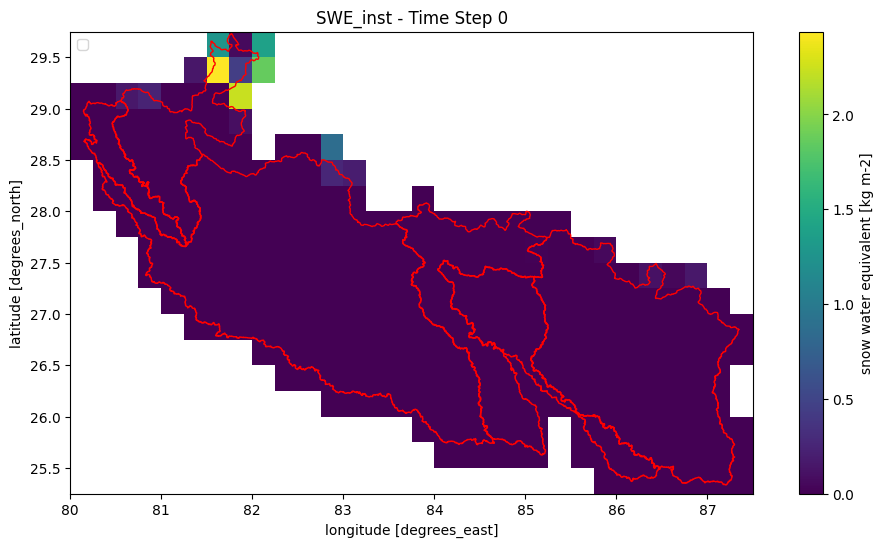

In [18]:
import matplotlib.pyplot as plt

# Ensure a variable is selected for plotting
variables = list(FLDAS_regrid.data_vars)  # List of variables in the dataset
print("Available variables for plotting:")
for idx, var in enumerate(variables):
    print(f"{idx + 1}: {var}")

# Prompt the user to select a variable
selected_index = int(input("Enter the number of the variable to plot: ")) - 1

if selected_index < 0 or selected_index >= len(variables):
    print("Invalid selection. Exiting...")
else:
    selected_var = variables[selected_index]
    print(f"Selected variable: {selected_var}")

    # Plot the selected variable with shapefile overlay
    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    # Plot the raster variable
    FLDAS_regrid[selected_var].isel(time=0).plot(ax=ax, cmap="viridis")  # Plot the first time step

    # Plot the shapefile
    nepal_shp.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, label="Nepal Boundary")

    # Add title and legend
    plt.title(f"{selected_var} - Time Step 0")
    plt.legend(loc='upper left')
    plt.show()



In [ ]:
import xarray as xr
import pandas as pd

# Define the start and end date for filtering
start_date = '2003-01-01'
end_date = '2023-12-31'
#FLDAS_regrid = FLDAS_regrid.rename({'X':'lon','Y':'lat'})
# List of variables in the dataset

vars = [variable for variable in FLDAS_regrid.variables]
#print(vars)
# Dictionary to store individual data arrays for each soil moisture component
dynamic_vars = {}
for i in range(8, 12):
    dynamic_vars["iget" + vars[i]] = FLDAS_regrid[vars[i]]
# Define a time-based mask to filter out missing dates
def get_time_mask(time_values, missing_dates):
    time_index = pd.to_datetime(time_values)
    mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

    for timestamp in missing_dates:
        year = timestamp.year
        month = timestamp.month
        # Exclude dates that match the missing year and month
        mask &= ~((time_index.year == year) & (time_index.month == month))

    return mask

# Export each component to a CSV file, sorted by longitude
for key, da in dynamic_vars.items():
    # Apply time mask to filter missing dates
    time_mask = get_time_mask(da['time'].values, missing_dates)
    da_filtered = da.sel(time=time_mask[time_mask].index)

    # Apply date range filter
    da_filtered = da_filtered.sel(time=slice(start_date, end_date))

    # Convert to DataFrame, reset index, and sort by 'lon'
    df = da_filtered.to_dataframe().reset_index()
    df = df.sort_values(by=['time','lon'])
    output_file = f"/content/drive/MyDrive/Thesis/RFM/Training/{key}.csv"
    df.to_csv(output_file, index=False)
    print(f"Exported {key} to {output_file}")




Exported igetSoilMoi00_10cm_tavg to /content/drive/MyDrive/Thesis/RFM/Training/igetSoilMoi00_10cm_tavg.csv
Exported igetSoilMoi10_40cm_tavg to /content/drive/MyDrive/Thesis/RFM/Training/igetSoilMoi10_40cm_tavg.csv
Exported igetSoilMoi40_100cm_tavg to /content/drive/MyDrive/Thesis/RFM/Training/igetSoilMoi40_100cm_tavg.csv
Exported igetSoilMoi100_200cm_tavg to /content/drive/MyDrive/Thesis/RFM/Training/igetSoilMoi100_200cm_tavg.csv


In [ ]:
FLDAS_regrid

<xarray.Dataset> Size: 7MB
Dimensions:                (time: 264, lon: 44, lat: 18)
Coordinates:
  * time                   (time) datetime64[ns] 2kB 2003-01-01 ... 2024-12-01
  * lon                    (lon) float64 352B 77.62 77.88 78.12 ... 88.12 88.38
  * lat                    (lat) float64 144B 24.62 24.88 25.12 ... 28.62 28.88
    spatial_ref            int64 8B 0
Data variables:
    Evap_tavg              (time, lat, lon) float32 836kB nan nan ... nan nan
    Qs_tavg                (time, lat, lon) float32 836kB nan nan ... nan nan
    RadT_tavg              (time, lat, lon) float32 836kB nan nan ... nan nan
    SWE_inst               (time, lat, lon) float32 836kB nan nan ... nan nan
    SoilMoi00_10cm_tavg    (time, lat, lon) float32 836kB nan nan ... nan nan
    SoilMoi10_40cm_tavg    (time, lat, lon) float32 836kB nan nan ... nan nan
    SoilMoi40_100cm_tavg   (time, lat, lon) float32 836kB nan nan ... nan nan
    SoilMoi100_200cm_tavg  (time, lat, lon) float32 836kB nan nan ... nan nan
Attributes: (12/20)
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    Conventions:               CF-1.4
    history:                   Fri Oct 30 12:23:26 2020: cdo -z zip_4 replace...
    institution:               NASA GSFC
    missing_value:             -9999.0
    NUM_SOIL_LAYERS:           4
    ...                        ...
    DX:                        0.1
    DY:                        0.1
    nco_openmp_thread_number:  1
    NCO:                       4.4.4
    history_L34RS:             'Created by L34RS v1.4.4 @ NASA GES DISC on Ja...
    CDO:                       Climate Data Operators version 1.9.8 (https://...

In [ ]:
import xarray as xr
import pandas as pd

# Define the start and end date for filtering
start_date = '2003-01-01'
end_date = '2023-12-31'


# Function to create a time-based mask to filter out missing dates
def get_time_mask(time_values, missing_dates):
    time_index = pd.to_datetime(time_values)
    mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

    for timestamp in missing_dates:
        year = timestamp.year
        month = timestamp.month
        # Exclude dates that match the missing year and month
        mask &= ~((time_index.year == year) & (time_index.month == month))

    return mask
soil_moisture_vars = [FLDAS_regrid[variable] for variable in list(FLDAS_regrid.variables)[8:12]]

# Combine the variables into a single dataset for easy handling
soil_moisture_data = xr.concat(soil_moisture_vars, dim="variable")

# Apply time-based mask to exclude missing dates
time_mask = get_time_mask(soil_moisture_data['time'].values, missing_dates)
filtered_time_indices = time_mask[time_mask].index
soil_moisture_data = soil_moisture_data.sel(time=filtered_time_indices)

# Apply date range filter
soil_moisture_data = soil_moisture_data.sel(time=slice(start_date, end_date))

# Calculate the mean across the 'variable' dimension
mean_soil_moisture = soil_moisture_data.mean(dim="variable")

# Convert to DataFrame
df_mean = mean_soil_moisture.to_dataframe().reset_index().rename(columns={mean_soil_moisture.name: "SM"})


# Sort the DataFrame by time, latitude, and longitude
df_mean = df_mean.sort_values(by=["time", "lon", "lat"])

# Export the combined data to a single CSV file
output_file = "/content/drive/MyDrive/Thesis/RFM/Training/SM.csv"
df_mean.to_csv(output_file, index=False)
print(f"Averaged soil moisture data exported to {output_file}")



Averaged soil moisture data exported to /content/drive/MyDrive/Thesis/RFM/Training/SM.csv


In [ ]:
#different way to export the average
# Save the regridded data to a NetCDF file
vars = [variable for variable in FLDAS_regrid.variables]
print(vars)
vars[8:12]
dynamic_vars = {}
for i in range(4, 8):
    dynamic_vars["iget" + vars[i]] = FLDAS_regrid[vars[i]]
average_data_array = None

# Loop through each DataArray in the dictionary and compute the mean
for key, da in dynamic_vars.items():
    if average_data_array is None:
        average_data_array = da
    else:
        average_data_array += da
average_data_array /= len(dynamic_vars)
average_data_array.name = "SM"
average_data_array
SM_df = average_data_array.to_dataframe().reset_index()
SM_df = SM_df.sort_values(by=['time', 'lon'])

#SM_df_drop = SM_df.drop(columns=['time','lat','lon'])
path = f'/content/drive/MyDrive/Thesis/RFM/Training/SM1.csv'
os.makedirs(os.path.dirname(path), exist_ok=True)
SM_df.to_csv(path,index = False)
SM_df

['Evap_tavg', 'Qs_tavg', 'RadT_tavg', 'SWE_inst', 'SoilMoi00_10cm_tavg', 'SoilMoi10_40cm_tavg', 'SoilMoi40_100cm_tavg', 'SoilMoi100_200cm_tavg', 'time', 'lon', 'lat', 'spatial_ref']


,time,lat,lon,spatial_ref,SM
0,2003-01-01,24.125,77.125,0,0.225959
48,2003-01-01,24.375,77.125,0,0.228084
96,2003-01-01,24.625,77.125,0,0.226870
144,2003-01-01,24.875,77.125,0,0.217204
192,2003-01-01,25.125,77.125,0,0.213777
...,...,...,...,...,...
303935,2024-12-01,28.875,88.875,0,0.358063
303983,2024-12-01,29.125,88.875,0,0.336715
304031,2024-12-01,29.375,88.875,0,0.314311
304079,2024-12-01,29.625,88.875,0,0.274122


In [ ]:
variables = list(FLDAS_regrid.variables)
variables

['time',
 'lon',
 'lat',
 'spatial_ref',
 'Evap_tavg',
 'Qs_tavg',
 'RadT_tavg',
 'SWE_inst',
 'SoilMoi00_10cm_tavg',
 'SoilMoi10_40cm_tavg',
 'SoilMoi40_100cm_tavg',
 'SoilMoi100_200cm_tavg']

## export specific variable

In [ ]:
import xarray as xr
import pandas as pd


start_date = '2003-01-01'
end_date = '2023-12-31'

# Function to create a time-based mask to filter out missing dates
def get_time_mask(time_values, missing_dates):
    time_index = pd.to_datetime(time_values)
    mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

    for timestamp in missing_dates:
        year = timestamp.year
        month = timestamp.month
        # Exclude dates that match the missing year and month
        mask &= ~((time_index.year == year) & (time_index.month == month))

    return mask

# Print all variables in the dataset
variables = list(FLDAS_regrid.variables)
print("Available variables in the dataset:")
for idx, variable in enumerate(variables):
    print(f"{idx + 1}: {variable}")

# Prompt the user to select variables
selected_indices = input(
    "Enter the numbers of the variables you want to export (comma-separated): "
)
selected_indices = [int(i.strip()) - 1 for i in selected_indices.split(",")]

# Validate selection
selected_variables = [variables[i] for i in selected_indices if 0 <= i < len(variables)]
if not selected_variables:
    print("No valid variables selected. Exiting...")
else:
    print(f"Selected variables: {selected_variables}")

# Prompt for output folder
output_folder = "/content/drive/MyDrive/Thesis/RFM/Training"

# Apply the time-based mask for missing dates
time_mask = get_time_mask(FLDAS_regrid['time'].values, missing_dates)
filtered_time_indices = time_mask[time_mask].index

# Export selected variables to individual CSV files
for variable in selected_variables:
    print(f"Processing variable: {variable}")
    da = FLDAS_regrid[variable]

    # Apply the time mask to exclude missing dates
    da_filtered = da.sel(time=filtered_time_indices)
    da_filtered = da_filtered.sel(time=slice(start_date, end_date))

    # Convert to DataFrame
    df = da_filtered.to_dataframe().reset_index()


    # Sort by all columns for consistency
    df = df.sort_values(by=['time','lon'])

    # Save the filtered data to CSV
    output_file = f"{output_folder}/{variable}.csv"
    df.to_csv(output_file, index=False)
    print(f"Exported {variable} to {output_file}")

print("Export completed.")


Available variables in the dataset:
1: time
2: lon
3: lat
4: spatial_ref
5: Evap_tavg
6: Qs_tavg
7: RadT_tavg
8: SWE_inst
9: SoilMoi00_10cm_tavg
10: SoilMoi10_40cm_tavg
11: SoilMoi40_100cm_tavg
12: SoilMoi100_200cm_tavg
Enter the numbers of the variables you want to export (comma-separated): 8
Selected variables: ['SWE_inst']
Processing variable: SWE_inst
Exported SWE_inst to /content/drive/MyDrive/Thesis/RFM/Training/SWE_inst.csv
Export completed.


###  NDVI

In [ ]:
file_path_nc ="/content/drive/MyDrive/Thesis/REGRID/NDVI_2003_2023.nc"
dataset = xr.open_dataset(file_path_nc)
regrid_lat = np.arange(21.125,32.125,0.25)
regrid_lon = np.arange(76.125,92.125,0.25)
NDVI = dataset['NDVI'].interp(lat = regrid_lat,lon=regrid_lon,method='nearest')
NDVI = NDVI.rio.write_crs('epsg:4326')
NDVI = NDVI.rename({'lon':'x','lat':'y'})
NDVI = NDVI.rio.clip(nepal_shp.geometry,all_touched=True)
NDVI = NDVI.transpose('time','x', 'y')
NDVI
time_index = pd.to_datetime(NDVI['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for timestamp in missing_dates:
    year = timestamp.year
    month = timestamp.month
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
filtered_dataset = NDVI.sel(time=mask[mask].index)
filtered_dataset = filtered_dataset.sel(time=slice('2003-02-01','2016-12-31'))

df = filtered_dataset.to_dataframe().reset_index()
df
# Export to CSV
what = 'NDVI'
df.to_csv(f'/content/drive/MyDrive/Thesis/RFM/Training/{cluster}/NDVI.csv', index=False)



In [ ]:
NDVI_NC = '/content/drive/MyDrive/Thesis/RAW/NDVI_REPROJECTED.nc'
NDVI = xr.open_dataset(NDVI_NC)
regrid_lat = np.arange(25.375,28.125,0.25)
regrid_lon = np.arange(84.125,87.625,0.25)
NDVI

<xarray.Dataset> Size: 1GB
Dimensions:             (time: 252, lat: 663, lon: 967)
Coordinates:
  * time                (time) object 2kB 2003-01-01 00:00:00 ... 2023-12-01 ...
  * lat                 (lat) float64 5kB 24.5 24.5 24.51 ... 30.0 30.0 30.01
  * lon                 (lon) float64 8kB 79.98 79.99 80.0 ... 88.01 88.02 88.03
Data variables:
    crs                 |S1 1B ...
    _1_km_monthly_NDVI  (time, lat, lon) float64 1GB ...
Attributes:
    Conventions:         CF-1.6
    history:             Wed Feb 05 20:11:34 2025: GDAL CreateCopy( D:/Master...
    institution:         Land Processes Distributed Active Archive Center (LP...
    references:          See README.md
    source:              AppEEARS v3.71
    title:               MOD13A3.061 for aid0001
    GDAL_AREA_OR_POINT:  Area
    GDAL:                GDAL 3.9.1, released 2024/06/22

In [ ]:
NDVI_RE = NDVI['_1_km_monthly_NDVI'].load().interp(lat = regrid_lat,lon=regrid_lon,method='nearest')
NDVI_RE = NDVI_RE.rio.write_crs('epsg:4326')
NDVI_RE = NDVI_RE.rio.clip(nepal_shp.geometry,all_touched=True)

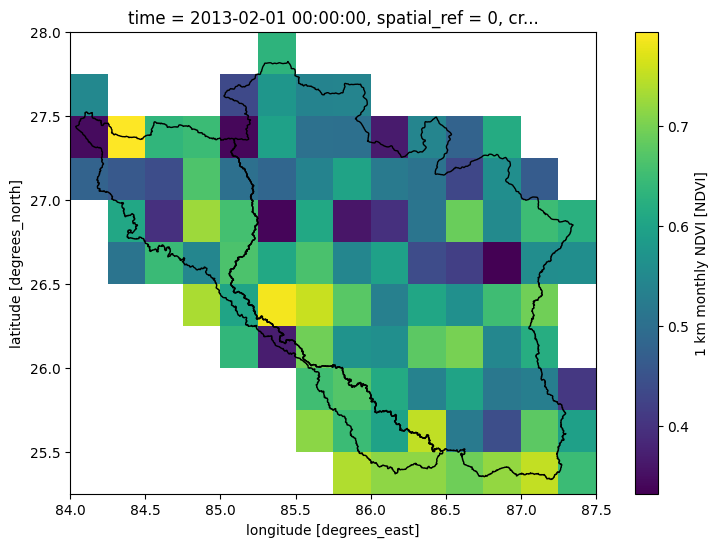

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

# Transpose the dataset to switch lat (y) and lon (x)
ndvi_pr = NDVI_RE.isel(time=121).transpose('lat', 'lon')
ndvi_pr.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

In [ ]:
#NDVI_RE['time'] = pd.to_datetime(NDVI_RE.indexes['time'].to_datetimeindex())
time_index = pd.to_datetime(NDVI_RE['time'].values)
mask = pd.Series(True, index=time_index)
for timestamp in missing_dates:
    year = timestamp.year
    month = timestamp.month
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))
NDVI_RE_subset = NDVI_RE.sel(time=mask[mask].index)
NDVI_RE_subset = NDVI_RE_subset.sel(time=slice('2003-01-01', '2023-12-31'))
ndvi_df = NDVI_RE_subset.to_dataframe().reset_index()
ndvi_df = ndvi_df.sort_values(by=['time','lon'])
ndvi_df.to_csv('/content/drive/MyDrive/Thesis/RFM/Training/ndvi_data.csv', index=False)

# GRACE

## Export GRACE into csv

In [ ]:
file_path_nc ="/content/drive/MyDrive/Thesis/RAW/GRACE_Aquifer.nc"
G_dataset = xr.open_dataset(file_path_nc)
G_dataset = G_dataset.rio.write_crs('epsg:4326')
G_dataset = G_dataset.rename({'lon':'x','lat':'y'})
G_dataset = G_dataset.rio.clip(nepal_shp.geometry,drop=True)
G_dataset_clip = G_dataset.sel(time=slice('2003-01-01','2023-12-31'))
G_dataset_clip = G_dataset_clip[['lwe_thickness']]
Gdf1 = G_dataset_clip.to_dataframe().reset_index()
Gdf1 = Gdf1.sort_values(by=['time', 'x'])
# Export to CSV
what = 'GRACE'
Gdf1.to_csv(f'/content/drive/MyDrive/Thesis/RFM/Training/GRACE.csv', index=False)
#missing_dates


In [ ]:
file_path_nc ="/content/drive/MyDrive/Thesis/RAW/GRACE_Aquifer.nc"
G_dataset = xr.open_dataset(file_path_nc)
G_dataset = G_dataset.rio.write_crs('epsg:4326')
G_dataset = G_dataset.rename({'lon':'x','lat':'y'})
G_dataset = G_dataset.rio.clip(nepal_shp.geometry,drop=True)
G_dataset_clip = G_dataset.sel(time=slice('2003-01-01','2023-12-31'))
G_dataset_clip = G_dataset_clip[['lwe_thickness']]
G_dataset_clip

<xarray.Dataset> Size: 702kB
Dimensions:        (time: 221, y: 18, x: 44)
Coordinates:
  * x              (x) float32 176B 77.62 77.88 78.12 ... 87.88 88.12 88.38
  * y              (y) float32 72B 24.62 24.88 25.12 25.38 ... 28.38 28.62 28.88
  * time           (time) datetime64[ns] 2kB 2003-01-16T12:00:00 ... 2023-12-...
    spatial_ref    int64 8B 0
    WGS84          int64 8B 0
Data variables:
    lwe_thickness  (time, y, x) float32 700kB nan nan nan nan ... nan nan nan
Attributes: (12/59)
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    filename:                   netcdf/CSR_GRACE_GRACE-FO_RL0603_Mascons_all-...
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    title:                      CSR GRACE and GRACE-FO MASCON RL0603M
    subtitle:                   RL06.2 GRACE/GRACE-FO Total water storage wit...
    ...                         ...
    user_note_3:                Ellipsoidal correction has been applied. The ...
    user_note_4:                This GRACE-FO RL06.2 data is an updated versi...
    date_created:               2025-01-06T11:43:54Z
    variable:                   liquid water equivalent thickness
    label:                      RL0603rc24cE
    Mask:                       Global

## DEM

### elevation

In [ ]:
path = '/content/drive/MyDrive/Thesis/RFM/Training/DEM'

In [ ]:
import rioxarray
import numpy as np

# Load the DEM file
dem_file = '/content/drive/MyDrive/Thesis/RAW/dem .25.tif'
dem = rioxarray.open_rasterio(dem_file)

# Clip the dataset using the Nepal shapefile geometry
dem = dem.rio.clip(nepal_shp.geometry, drop=True)

# Replace _FillValue with NaN
if '_FillValue' in dataset.attrs:
    fill_value = dem.attrs['_FillValue']
    dem = dem.where(dataset != fill_value, np.nan)

# Display the dataset
dem


<xarray.DataArray (band: 1, y: 18, x: 44)> Size: 6kB
array([[[-32768., -32768., -32768., -32768., -32768., -32768.,    192.,
            197.,    203.,    203.,    194.,    214.,    668., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768.],
        [-32768., -32768., -32768., -32768.,    197.,    192.,    179.,
            180.,    185.,    190.,    194.,    170.,    181.,    178.,
            173., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768.],
        [-32768.,    198.,    199.,    184.,    190.,    183.,    175.,
            162.,    171.,    172.,    172.,    166.,    153.,    146.,
            145.,    182.,    399., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
...
         -32768., -32768., -32768., -32768.,    147.,    146.,    167.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
            109.,     80.,     80.,     82.,     87.,     94.,     90.,
             78.,     76., -32768., -32768., -32768.,     49., -32768.,
         -32768.,     46.,     43.,     39.,     77., -32768., -32768.,
         -32768., -32768.],
        [-32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768.,    103.,    121.,     98.,
             99.,    101., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768.],
        [-32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768.,    139.,    139.,
            146.,    133., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768., -32768., -32768., -32768., -32768., -32768.,
         -32768., -32768.]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 352B 77.62 77.87 78.12 78.37 ... 87.87 88.12 88.37
  * y            (y) float64 144B 28.88 28.63 28.38 28.13 ... 25.13 24.88 24.63
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -32768

In [ ]:
dem.name = "elevation"
demdf = dem.to_dataframe().reset_index()
demdf = demdf.sort_values(by=['x','y'])
demdf
# Export to CSV
os.makedirs(path, exist_ok=True)
demdf.to_csv(f'{path}/elevation.csv', index=False)

### Slope

In [ ]:
import rioxarray
slope_file = "/content/drive/MyDrive/Thesis/REGRID/Slope.tif"
slope_ds = rioxarray.open_rasterio(slope_file)

# Set the current CRS and reproject to EPSG:4326
slope_ds = slope_ds.rio.write_crs("EPSG:32645")  # Original CRS
slope_ds = slope_ds.rio.reproject("EPSG:4326")
regrid_lat = np.arange(21.125,32.125,0.25)
regrid_lon = np.arange(76.125,92.125,0.25)
slope = slope_ds.interp(y = regrid_lat,x=regrid_lon,method='slinear')

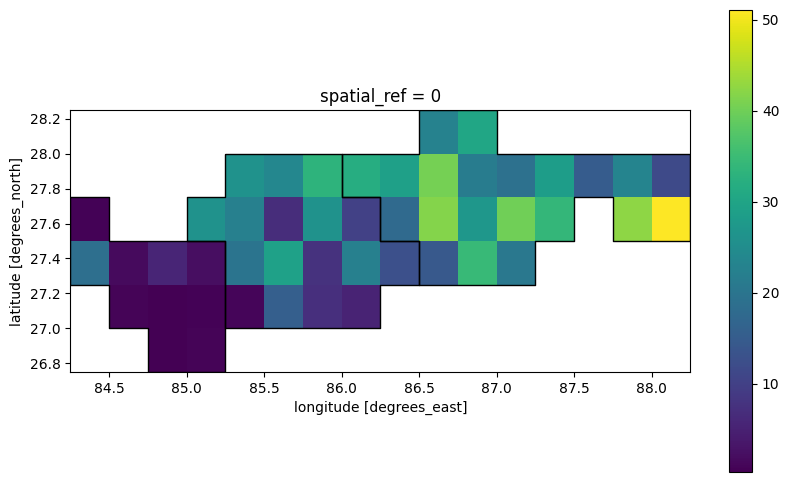

In [ ]:
import rioxarray
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

#slope = slope.squeeze(dim="band", drop=True)
slope = slope.rio.clip(nepal_shp.geometry,all_touched= True)
fill_value = slope.attrs.get('_FillValue', None)
slope = slope.where(slope != fill_value, np.nan)
#tolerance = 0.01
#slope = slope.where(~((slope > -9999 - tolerance) & (slope < -9999 + tolerance)), np.nan)

#slope = slope.where(slope != 0, np.nan)
# Transpose the dataset to switch lat (y) and lon (x)
slope_tr = slope.transpose('y', 'x')
slope_tr.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

In [ ]:
slope.name = "slope"
slopedf = slope.to_dataframe().reset_index()
slopedf = slopedf.sort_values(by=['x','y'])
slopedf
# Export to CSV
slopedf.to_csv(f'{path}/slope.csv', index=False)

### Aspect

In [ ]:
import rioxarray
aspect_file = "/content/drive/MyDrive/Thesis/REGRID/Aspect.tif"
aspect_ds = rioxarray.open_rasterio(aspect_file)

# Set the current CRS and reproject to EPSG:4326
aspect_ds = aspect_ds.rio.write_crs("EPSG:32645")  # Original CRS
aspect_ds = aspect_ds.rio.reproject("EPSG:4326")
regrid_lat = np.arange(21.125,32.125,0.25)
regrid_lon = np.arange(76.125,92.125,0.25)
aspect = aspect_ds.interp(y = regrid_lat,x=regrid_lon,method='slinear')

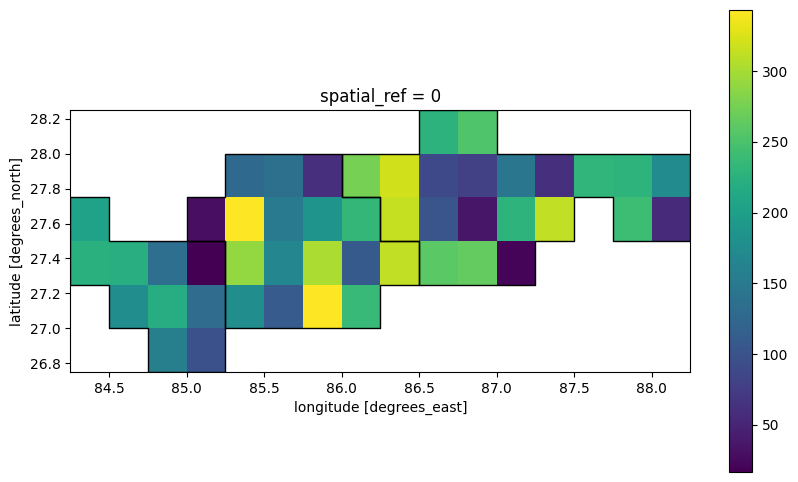

In [ ]:
import rioxarray
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

aspect = aspect.squeeze(dim="band", drop=True)
aspect = aspect.rio.clip(nepal_shp.geometry,all_touched= True)
fill_value = aspect.attrs.get('_FillValue', None)
aspect = aspect.where(aspect != fill_value, np.nan)
#tolerance = 0.01
#aspect = aspect.where(~((aspect > -9999 - tolerance) & (aspect < -9999 + tolerance)), np.nan)

#aspect = aspect.where(aspect != 0, np.nan)
# Transpose the dataset to switch lat (y) and lon (x)
aspect_tr = aspect.transpose('y', 'x')
aspect_tr.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

In [ ]:
aspect.name = "aspect"
aspectdf = aspect.to_dataframe().reset_index()
aspectdf = aspectdf.sort_values(by=['x','y'])
aspectdf
# Export to CSV
aspectdf.to_csv(f'{path}/aspect.csv', index=False)

### Repeat

In [ ]:
import pandas as pd
import os

# Folder containing the CSV files
input_folder = f'/content/drive/MyDrive/Thesis/RFM/Training/DEM'
output_folder = f'/content/drive/MyDrive/Thesis/RFM/Training/'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Step 2: Create a date range from 2003-02-01 to 2016-12-31 (monthly frequency)
date_range = pd.date_range(start='2003-01-01', end='2023-12-31', freq='MS')

# Define missing dates and convert to datetime
missing_dates = pd.to_datetime(missing_dates, format='%Y-%m')
filtered_date_range = date_range[~date_range.isin(missing_dates)]

# Loop through each CSV file in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        # Step 1: Read each original CSV file
        file_path = os.path.join(input_folder, file_name)
        original_data = pd.read_csv(file_path)

        # Step 5: Repeat the original data for each valid date (excluding the missing ones)
        extended_data = pd.concat([original_data] * len(filtered_date_range), ignore_index=True)
        extended_data['time'] = filtered_date_range.repeat(len(original_data)).values

        # Step 6: Export the new data with the time dimension to a new CSV file
        output_file = os.path.join(output_folder, f'extended_{file_name}')
        extended_data.to_csv(output_file, index=False)

        print(f"Processed and saved {output_file}")

print("All files have been processed and saved.")


Processed and saved /content/drive/MyDrive/Thesis/RFM/Training/extended_elevation.csv
All files have been processed and saved.


# Check number of data in each CSV Files

In [ ]:
import os
import pandas as pd

# Path to the folder containing the CSV files
folder_path = f'/content/drive/MyDrive/Thesis/RFM/Training/'

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):  # Only process CSV files
        file_path = os.path.join(folder_path, filename)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Print the file name and the number of rows
        print(f'File: {filename}, Number of rows: {len(df)}')


File: extended_elevation.csv, Number of rows: 34034
File: extended_aspect.csv, Number of rows: 34034
File: precipitation.csv, Number of rows: 34034
File: SM.csv, Number of rows: 34034
File: Evap_tavg.csv, Number of rows: 34034
File: Qs_tavg.csv, Number of rows: 34034
File: RadT_tavg.csv, Number of rows: 34034
File: SWE_inst.csv, Number of rows: 34034
File: GRACE.csv, Number of rows: 34034
File: combined_csv.csv, Number of rows: 34034
File: ndvi_data.csv, Number of rows: 34034


# Combine the csv files

In [ ]:
import os
import pandas as pd

# Function to get the columns to copy from each CSV file
def select_columns(df, file_name):
    print(f"Available columns in {file_name}:")
    print(df.columns.tolist())

    # Ask the user for the column names they want to copy
    selected_columns = input("Enter the columns to copy (separated by commas): ").split(",")
    selected_columns = [col.strip() for col in selected_columns]  # Remove leading/trailing spaces
    return df[selected_columns]

# Folder where the CSV files are located
folder_path = f'/content/drive/MyDrive/Thesis/RFM/Training/'

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Ask the user which columns to copy
        selected_data = select_columns(df, file_name)

        # Add the selected columns to the combined DataFrame
        combined_df = pd.concat([combined_df, selected_data], axis=1)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv(f"/content/drive/MyDrive/Thesis/RFM/Training/combined_csv.csv", index=False)
print("Combined CSV file created: combined_csv_file.csv")


Available columns in extended_elevation.csv:
['band', 'y', 'x', 'spatial_ref', 'elevation', 'time']
Enter the columns to copy (separated by commas): elevation
Available columns in extended_aspect.csv:
['y', 'x', 'spatial_ref', 'aspect', 'time']
Enter the columns to copy (separated by commas): aspect
Available columns in precipitation.csv:
['time', 'x', 'y', 'precipitation']
Enter the columns to copy (separated by commas): precipitation
Available columns in SM.csv:
['time', 'lat', 'lon', 'spatial_ref', 'SM']
Enter the columns to copy (separated by commas): time, lat, lon, SM
Available columns in Evap_tavg.csv:
['time', 'lat', 'lon', 'spatial_ref', 'Evap_tavg']
Enter the columns to copy (separated by commas): Evap_tavg
Available columns in Qs_tavg.csv:
['time', 'lat', 'lon', 'spatial_ref', 'Qs_tavg']
Enter the columns to copy (separated by commas): Qs_tavg
Available columns in RadT_tavg.csv:
['time', 'lat', 'lon', 'spatial_ref', 'RadT_tavg']
Enter the columns to copy (separated by commas

In [ ]:
import os
import pandas as pd

# Specify the folder containing the CSV files
folder_path = '/content/drive/MyDrive/Thesis/RFM/Training/'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Loop through each CSV file and display its first few rows
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    try:
        df = pd.read_csv(file_path)  # Read the CSV file
        print(f"Preview of {file}:")
        print(df.head())  # Display first 5 rows
        print("\n" + "-"*50 + "\n")  # Separator for better readability
    except Exception as e:
        print(f"Could not read {file}: {e}")

Preview of GRACE.csv:
                  time       y       x  lwe_thickness  spatial_ref  WGS84
0  2003-01-16 12:00:00  24.625  77.625            NaN            0      0
1  2003-01-16 12:00:00  24.875  77.625            NaN            0      0
2  2003-01-16 12:00:00  25.125  77.625            NaN            0      0
3  2003-01-16 12:00:00  25.375  77.625            NaN            0      0
4  2003-01-16 12:00:00  25.625  77.625            NaN            0      0

--------------------------------------------------

Preview of Qs_tavg.csv:
         time     lat     lon  spatial_ref  Qs_tavg
0  2003-01-01  24.625  77.625            0      NaN
1  2003-01-01  24.875  77.625            0      NaN
2  2003-01-01  25.125  77.625            0      NaN
3  2003-01-01  25.375  77.625            0      NaN
4  2003-01-01  25.625  77.625            0      NaN

--------------------------------------------------

Preview of RadT_tavg.csv:
         time     lat     lon  spatial_ref  RadT_tavg
0  2003-01-0

In [ ]:
path1 = "D:/Masters/Thesis/Data/RFM/combined_csv_file.csv"
csv = pd.read_csv(path1)
csv

# Predictor Model Data Preparation

### Missing Dates of GRACE

In [ ]:
what = 'GRACE_Clipped_converted'
file_path_nc ="D:/Masters/Thesis/Data/ReGrid/"+what + ".nc"
G_dataset = xr.open_dataset(file_path_nc)
months_missing = G_dataset.attrs.get('months_missing', 'Attribute not found')
dates = months_missing.replace(",", ";").split(";")
missing_dates = [(int(date.split("-")[0]), int(date.split("-")[1])) for date in dates]

### Target Resolution (FLDAS)

In [ ]:
FLDAS_path ="D:/Masters/Thesis/Data/Combined_FLDAS.nc"
FLDAS = xr.open_dataset(FLDAS_path)
FLDAS = FLDAS.rename({'X':'lon','Y':'lat'})
#FLDAS['time'] = pd.to_datetime(FLDAS.indexes['time'].to_datetimeindex())  #if the time is not in standard format

time_index = pd.to_datetime(FLDAS['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for year, month in missing_dates:
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
FLDAS_N = FLDAS.sel(time=mask[mask].index)
FLDAS_N = FLDAS_N.sel(time=slice('2003-02-01','2016-12-31'))
FLDAS_N
#FLDAS_N = FLDAS_N.drop(columns=['time','X','Y'])
#data_array - data_array.rename({'X':'lon','Y':'lat'})
#path = "D:\Masters\Thesis\Data\Predictor\SM.csv"
#FLDAS_N.to_csv(path,index = False)

#### Average SM and Export to csv

In [ ]:
# Save the regridded data to a NetCDF file
import xarray as xr
vars = [variable for variable in FLDAS_N.variables]
print(vars)
vars[8:12]
dynamic_vars = {}
for i in range(8, 12):
    dynamic_vars["iget" + vars[i]] = FLDAS_N[vars[i]]
average_data_array = None

# Loop through each DataArray in the dictionary and compute the mean
for key, da in dynamic_vars.items():
    if average_data_array is None:
        average_data_array = da
    else:
        average_data_array += da
average_data_array /= len(dynamic_vars)
average_data_array.name = "SM"
average_data_array
SM_df = average_data_array.to_dataframe().reset_index()
SM_df = SM_df.sort_values(by=['time', 'lon'])

SM_df_drop = SM_df.drop(columns=['time','lat','lon'])
path = "D:\Masters\Thesis\Data\Predictor\SM.csv"
SM_df_drop.to_csv(path,index = False)
SM_df


#### Other data from FLDAS

In [ ]:
vars = [variable for variable in FLDAS_N.variables]
i = 4
which  = vars[i]
what = FLDAS_N[vars[i]]
what_df = what.to_dataframe().reset_index()
what_df = what_df.sort_values(by=['time', 'lon'])

#what_df_drop = what_df.drop(columns=['time','lon','lat'])
path = "D:/Masters/Thesis/Data/Predictor/" + which + ".csv"
what_df.to_csv(path,index = False)
what_df

In [ ]:
# Ask for the index of the variable to export
index_to_export = int(input("Enter the index of the variable to export: "))

# Retrieve the variable name based on the index
var_name = vars[index_to_export]

# Extract the variable from the dataset
selected_var = FLDAS_N[var_name]

# Convert the selected variable to a DataFrame and reset index
selected_var_df = selected_var.to_dataframe().reset_index()

# Drop unnecessary columns (you can adjust this if needed)
selected_var_df = selected_var_df.drop(columns=['time', 'X', 'Y'])

# Dynamically generate the CSV file name based on the variable name
csv_path = f"D:/Masters/Thesis/Data/Predictor/{var_name}.csv"

# Export the DataFrame to CSV
selected_var_df.to_csv(csv_path, index=False)

print(f"Exported {var_name} to {csv_path}")
csv = pd.read_csv(csv_path)
csv

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
lst = xr.open_dataset('D:/Masters/Thesis/Data/Combined_FLDAS.nc')
variables = [variable for variable in lst.variables]
print(variables)
which = variables[6]
which
time = lst['time']
#display(time)
# Assuming lst is an xarray Dataset
#lst = lst.transpose('time', 'x', 'y')  # Transpose if necessary
# Check if lat/lon are correctly labeled, otherwise rename them
#lst = lst.rename({'lat': 'Y', 'lon': 'X'})
for yr in range(2004,2005):
  filt_time = time.sel(time=time.dt.year==yr)
  display(filt_time)
  fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
  axes = axes.flatten()
  i=1
  # Plot each month
  for t in filt_time:
      monthly_data = lst.sel(time=t)
      #print(t)
      # Assuming you want to plot the first variable in the dataset
      monthly_data[which].plot(ax=axes[i-1],cmap = 'viridis')
      #axes[i].set_title(f'Month {i}')
      i+=1

  # Adjust layout
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.4, wspace=0.4)
  #plt.savefig(f'/content/drive/MyDrive/Thesis_folder/pre_processed_data/IMERG/{yr}.png', bbox_inches='tight', dpi=300)
  plt.show()
countnan = lst[which].isnull().sum()
print(countnan)
print(which)

### Precipitation

In [ ]:
file_path_nc ="D:/Masters/Thesis/Data/Combined_IMERG.nc4"
ppt = xr.open_dataset(file_path_nc)
ppt['time'] = pd.to_datetime(ppt.indexes['time'].to_datetimeindex())  #if the time is not in standard format

time_index = pd.to_datetime(ppt['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for year, month in missing_dates:
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
filtered_ppt = ppt.sel(time=mask[mask].index)
filtered_ppt = filtered_ppt.sel(time=slice('2003-02-01','2020-12-31'))

regrid_lat = np.arange(21.05,32.05,0.1)
regrid_lon = np.arange(76.05,92.05,0.1)
ppt_new = filtered_ppt.interp( lat = regrid_lat,lon = regrid_lon, method='slinear')
ppt_df = ppt_new.to_dataframe().reset_index()
#ppt_df = ppt_df.sort_values(by=['time', 'lat'])
ppt_df_drop = ppt_df.drop(columns=['time','lon','lat'])
path = "D:\Masters\Thesis\Data\Predictor\ppt_df.csv"
ppt_df_drop.to_csv(path,index = False)
ppt_df


### NDVI

In [ ]:
file_path_nc ="D:/Masters/Thesis/Data/NDVI/NDVI_2003_2023.nc"
dataset = xr.open_dataset(file_path_nc)
regrid_lat = np.arange(21.05,32.05,0.1)
regrid_lon = np.arange(76.05,92.05,0.1)
NDVI = dataset['NDVI'].interp(lat = regrid_lat,lon=regrid_lon,method='slinear')
NDVI
time_index = pd.to_datetime(NDVI['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for year, month in missing_dates:
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
filtered_dataset = NDVI.sel(time=mask[mask].index)
filtered_dataset = filtered_dataset.sel(time=slice('2003-02-01','2020-12-31'))

NDVI_df = filtered_dataset.to_dataframe().reset_index()
#NDVI_df = NDVI_df.sort_values(by=['time', 'lat'])
NDVI_df_drop = NDVI_df.drop(columns=['time','lon','lat'])

# Export to CSV
what = 'NDVI'
NDVI_df_drop.to_csv('D:/Masters/Thesis/Data/Predictor/'+what+'.csv', index=False)
path = 'D:/Masters/Thesis/Data/Predictor/'+what+'.csv'
NDVI_df

## Check number of data in csv

In [ ]:
import os
import pandas as pd

# Path to the folder containing the CSV files
folder_path = 'D:/Masters/Thesis/Data/Predictor/'

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):  # Only process CSV files
        file_path = os.path.join(folder_path, filename)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Print the file name and the number of rows
        print(f'File: {filename}, Number of rows: {len(df)}')

### DEM, Aspect and Slope

#### Visualize

#### Export to 0.25

In [ ]:
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt

# File paths
dem_file = 'D:/Masters/Thesis_New/DEM/DEM_0.25.tif'  # Path to your DEM file
shapefile_path = 'D:/Masters/Thesis_New/Study Area.shp'  # Path to your shapefile

# Load the shapefile
nepal_shp = gpd.read_file(shapefile_path)

# Load the DEM file and assign the CRS (if not already set)
dem = rioxarray.open_rasterio(dem_file)
dem = dem.rio.write_crs('epsg:4326')

# Clip the DEM file using the shapefile
dem_clipped = dem.rio.clip(nepal_shp.geometry, all_touched=True)

# Plot the clipped DEM
fig, ax = plt.subplots(figsize=(10, 6))
dem_clipped.plot(ax=ax)
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')  # Plot the shapefile boundaries
plt.title("Clipped DEM")
plt.show()

# Save the clipped DEM if needed
output_dem_file = 'D:/Masters/Thesis_New/DEM/clipped.tif'
dem_clipped.rio.to_raster(output_dem_file)


In [ ]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Open the DEM dataset
file_path_nc = "D:/Masters/Thesis_New/DEM/clipped original.tif"
DEM = xr.open_dataset(file_path_nc)

# Define the regridding lat and lon values with the desired resolution
regrid_lat = np.arange(26.125, 29.625, 0.25)
regrid_lon = np.arange(79.875, 88.375, 0.25)

# Perform interpolation with 'nearest' method
regrid_DEM = DEM.interp(x=regrid_lon, y=regrid_lat, method='nearest')
regrid_DEM = regrid_DEM.rename({'x': 'lon', 'y': 'lat'})

# Extract the data array from the regridded DEM
data_array = regrid_DEM['band_data'].squeeze()  # Remove extra dimensions if any

# Flip the array vertically (north-south direction)
data_array_flipped = np.flipud(data_array)

# Define the transform (affine) based on regridded lat/lon
transform = from_origin(west=min(regrid_lon), north=max(regrid_lat), xsize=0.25, ysize=0.25)

# Export the regridded DEM to a GeoTIFF file
DEM_0_25_path = 'D:/Masters/Thesis_New/DEM/DEM_0.25_2.tif'
with rasterio.open(
    DEM_0_25_path,
    'w',  # Write mode
    driver='GTiff',
    height=data_array_flipped.shape[0],
    width=data_array_flipped.shape[1],
    count=1,
    dtype=data_array_flipped.dtype,
    crs="EPSG:4326",
    transform=transform
) as dst:
    dst.write(data_array_flipped, 1)  # Write flipped data to the first band
data_array_flipped

#### Export to 0.1

In [ ]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Open the DEM dataset
file_path_nc = "D:/Masters/Thesis/Data/newdem.tif"
DEM = xr.open_dataset(file_path_nc)

# Define the regridding lat and lon values with the desired resolution
regrid_lat = np.arange(21.05,32.05,0.1)
regrid_lon = np.arange(76.05,92.05,0.1)

# Perform interpolation with 'nearest' method
regrid_DEM = DEM.interp(x=regrid_lon, y=regrid_lat, method='nearest')
regrid_DEM = regrid_DEM.rename({'x': 'lon', 'y': 'lat'})

# Extract the data array from the regridded DEM
data_array = regrid_DEM['band_data'].squeeze()  # Remove extra dimensions if any

# Flip the array vertically (north-south direction)
data_array_flipped = np.flipud(data_array)

# Define the transform (affine) based on regridded lat/lon
transform = from_origin(west=min(regrid_lon), north=max(regrid_lat), xsize=0.1, ysize=0.1)

# Export the regridded DEM to a GeoTIFF file
DEM_0_25_path = 'D:/Masters/Thesis/Data/DEM_0.1.tif'
with rasterio.open(
    DEM_0_25_path,
    'w',  # Write mode
    driver='GTiff',
    height=data_array_flipped.shape[0],
    width=data_array_flipped.shape[1],
    count=1,
    dtype=data_array_flipped.dtype,
    crs="EPSG:4326",
    transform=transform
) as dst:
    dst.write(data_array_flipped, 1)  # Write flipped data to the first band

In [ ]:

dem_df = regrid_DEM.to_dataframe().reset_index()
dem_df = dem_df.sort_values(by=['lon', 'lat']).reset_index(drop=True)
dem_df
# Export to CSV
what = 'elev'
dem_df.to_csv('D:/Masters/Thesis/Data/Predictor/'+what+'.csv', index=False)
dem_df




#### Export to CSV

In [ ]:
import xarray as xr

file_path_nc = "D:/Masters/Thesis_New/DEM 2/aspect_0.25.tif"
DEM = xr.open_dataset(file_path_nc)

# Define the regridding lat and lon values with the desired resolution
regrid_lat = np.arange(26.125, 29.625, 0.25)
regrid_lon = np.arange(79.875, 88.375, 0.25)

# Perform interpolation with 'nearest' method
regrid_DEM = DEM.interp(x=regrid_lon, y=regrid_lat, method='nearest')
regrid_DEM = regrid_DEM.rename({'x': 'lon', 'y': 'lat'})
aspect_nc = xr.open_dataset(file_path_nc)
aspect_nc = aspect_nc.rio.write_crs('epsg:4326')
aspect_nc = aspect_nc.rio.clip(nepal_shp.geometry, all_touched=True)

# Remove the first value from 'x' and 'y'
aspect_nc = aspect_nc.isel(x=slice(1, None), y=slice(1, None))

aspect_nc


In [ ]:
aspect = aspect_nc.to_dataframe().reset_index()
aspect = aspect.sort_values(by=['x', 'y']).reset_index(drop=True)
# Export to CSV
what = 'aspect'
aspect.to_csv('D:/Masters/Thesis_New/DEM/'+what+'.csv', index=False)



In [ ]:
file_path_nc = "D:/Masters/Thesis/Data/slope_0.1.nc"
slope_nc = xr.open_dataset(file_path_nc)
slope = slope_nc.to_dataframe().reset_index()
slope = slope.sort_values(by=['lon', 'lat']).reset_index(drop=True)
# Export to CSV
what = 'slope'
slope.to_csv('D:/Masters/Thesis/Data/Predictor/'+what+'.csv', index=False)

#### Repeat for time

In [ ]:
import pandas as pd


#Step 1: Read the original CSV file
original_data = pd.read_csv('D:/Masters/Thesis_New/DEM/dem_data_Cluster5.csv')

# Step 2: Create a date range from 2003-02-01 to 2020-12-31 (monthly frequency)
date_range = pd.date_range(start='2003-02-01', end='2016-12-31', freq='MS')

# Step 4: Convert 'missing_date' to datetime and filter out those dates from the date_range
missing_dates = pd.to_datetime(missing_dates, format='%Y-%m')
filtered_date_range = date_range[~date_range.isin(missing_dates)]

# Step 5: Repeat the original data for each valid date (excluding the missing ones)
extended_data = pd.concat([original_data] * len(filtered_date_range), ignore_index=True)
extended_data['time'] = filtered_date_range.repeat(len(original_data)).values

# Step 6: Export the new data with the time dimension to a CSV file
extended_data.to_csv('D:/Masters/Thesis_New/Terai/RFM/DEM_slope_aspect_new.csv', index=False)

print("New CSV file excluding the specified dates has been saved.")

In [ ]:
path = 'D:/Masters/Thesis/Data/Predictor/DEM_slope_aspect_new.csv'
csv = pd.read_csv(path)
csv

#### Combine CSV file

In [ ]:
import os
import pandas as pd

# Function to get the columns to copy from each CSV file
def select_columns(df, file_name):
    print(f"Available columns in {file_name}:")
    print(df.columns.tolist())

    # Ask the user for the column names they want to copy
    selected_columns = input("Enter the columns to copy (separated by commas): ").split(",")
    selected_columns = [col.strip() for col in selected_columns]  # Remove leading/trailing spaces
    return df[selected_columns]

# Folder where the CSV files are located
folder_path = 'D:/Masters/Thesis_New/Terai/RFM/'

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Ask the user which columns to copy
        selected_data = select_columns(df, file_name)

        # Add the selected columns to the combined DataFrame
        combined_df = pd.concat([combined_df, selected_data], axis=1)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv("D:/Masters/Thesis_New/Terai/RFM/Cluster 5.csv", index=False)
print("Combined CSV file created: combined_csv_file.csv")


In [ ]:
path = "D:/Masters/Thesis/Data/Predictor/combined_predictor.csv"
csv = pd.read_csv(path)
csv

# Downscaled Product visualize

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
lst = xr.open_dataset('D:/Masters/Thesis/Data/GRACE_0.1.nc')
variables = [variable for variable in lst.variables]
print(variables)

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the dataset
lst = xr.open_dataset('D:/Masters/Thesis/Data/GRACE_0.1.nc')

# Check the available variables to ensure 'lwe_thickness_predict' exists
variables = [variable for variable in lst.variables]
print("Available variables:", variables)

# Define the variable to plot
variable_name = 'lwe_thickness_predict'

# Ensure the variable exists in the dataset
if variable_name not in lst:
    raise ValueError(f"Variable '{variable_name}' not found in the dataset.")

# Extract the time dimension
time = lst['time']

# Convert the time values in the dataset to pandas timestamps
time_values = pd.to_datetime(time.values)


# Define the specific time to visualize
specific_time = '2005-07-01'  # Example: 'YYYY-MM-DD' or use an index
#specific_time = pd.Timestamp(specific_time)

# Select the data for the specific time using the 'nearest' method
data_at_time = lst[variable_name].sel(time=specific_time)

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use a cartographic projection

# Plot the data
data_at_time.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add political boundaries, coastlines, and other features
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')  # Political boundaries
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor='black')  # Coastlines


# Add a title and labels
plt.title(f'{variable_name} on {specific_time}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot with political boundaries
plt.colorbar(label=variable_name)
plt.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Load the dataset
lst = xr.open_dataset('D:/Masters/Thesis/Data/GRACE_Clipped_converted.nc')

# Check the available variables to ensure 'lwe_thickness_predict' exists
variables = [variable for variable in lst.variables]
#print("Available variables:", variables)

# Define the variable to plot
variable_name = 'lwe_thickness'

# Ensure the variable exists in the dataset
if variable_name not in lst:
    raise ValueError(f"Variable '{variable_name}' not found in the dataset.")

# Extract the time dimension
time = lst['time']

# Convert the time values in the dataset to pandas timestamps
time_values = pd.to_datetime(time.values)

# Print the available time values to select a specific one
print("Available time values:", time_values)

# Define the specific time to visualize
#specific_time = '2003-02-01'  # Example: 'YYYY-MM-DD' or use an index
#specific_time = pd.Timestamp(specific_time)

# Select the data for the specific time using the 'nearest' method
data_at_time = lst[variable_name].sel(time=specific_time, method='nearest')
exact_time = data_at_time['time'].values
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use a cartographic projection

# Plot the data
data_at_time.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add political boundaries, coastlines, and other features
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')  # Political boundaries
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor='black')  # Coastlines


# Add a title and labels
plt.title(f'{variable_name} on {exact_time}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot with political boundaries
plt.colorbar(label=variable_name)
plt.show()



In [ ]:
data_at_time['time'].values

# Handling Residuals

In [ ]:
grace_pr = xr.open_dataset('D:/Masters/Thesis/Data/GRACE_0.1.nc')
grace_ori = xr.open_dataset('D:/Masters/Thesis/Data/GRACE_Clipped_converted.nc')


In [ ]:
import numpy as np
regrid_lat = np.arange(21.125,32.125,0.25)
regrid_lon = np.arange(76.125,92.125,0.25)
grace_pr_regrid = grace_pr.interp(lon=regrid_lon,lat = regrid_lat,method='slinear')
grace_pr_regrid
grace_pr_df = grace_pr_regrid.to_dataframe().reset_index()
grace_pr_df = grace_pr_df.sort_values(by=['time', 'lon'])
grace_pr_df

In [ ]:
grace_ori_f = grace_ori.sel(time=slice('2003-02-01','2020-12-31'))
grace_ori_f = grace_ori_f.isel(timebound=0)
grace_ori_df = grace_ori_f.to_dataframe().reset_index()
grace_ori_df = grace_ori_df.sort_values(by=['time', 'lon'])
grace_ori_df